In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/SRFP/DPIR
!ls

/content/drive/MyDrive/SRFP/DPIR
 ADMM_restomer.ipynb			 LICENSE
'ADMM_restomer_Super 3.ipynb'		 main_download_pretrained_models.py
 ADMM_restomer_Super.ipynb		 main_dpir_deblocking_color.py
'Copy of ADMM_restomer_Super 2 .ipynb'	 main_dpir_deblocking_grayscale.py
'Copy of ISTA_Restomer_SuperRes.ipynb'	 main_dpir_deblur.py
 DPIR_deblur.ipynb			 main_dpir_demosaick.py
 DPIR_deblur_restomer_FineTuning.ipynb	 main_dpir_denoising.py
 DPIR_Denoising_drunet_color.ipynb	 main_dpir_sisr.py
 DPIR_sigma15_Denoising_Restomer.ipynb	 main_dpir_sisr_real_applications.py
 DPIR_sisr.ipynb			 models
 DPIR_sisr_restomer_FineTuning.ipynb	 model_zoo
 figs					 README.md
 ISTA_Restomer.ipynb			 results
 ISTA_Restomer_SuperRes.ipynb		 testsets
 kernels				 utils


In [1]:
!pip install einops
!pip install hdf5storage
from runpy import run_path

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
# -*- coding: utf-8 -*-
import numpy as np


'''
modified by Kai Zhang (github: https://github.com/cszn)
03/03/2019
'''


# --------------------------------
# get rho and sigma
# --------------------------------
#def get_rho_sigma(sigma=2.55/255, iter_num=15, modelSigma1=49.0, modelSigma2=2.55):
#    '''
#    One can change the sigma to implicitly change the trade-off parameter
#    between fidelity term and prior term
#    '''
#    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
#    sigmas = modelSigmaS/255.
#    rhos = list(map(lambda x: 0.23*(sigma**2)/(x**2), sigmas))
#    return rhos, sigmas

# --------------------------------
# get rho and sigma
# --------------------------------
def get_rho_sigma(Lam, sigma=2.55/255, iter_num=15, modelSigma1=49.0, modelSigma2=2.55, w=1.0 ): #rhos, sigmas = pnp.get_rho_sigma(sigma=max(0.255/255., noise_level_model), iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1.0)
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    modelSigmaS_lin = np.linspace(modelSigma1, modelSigma2, iter_num).astype(np.float32) 
    sigmas = (modelSigmaS*w+modelSigmaS_lin*(1-w))/255.        
    rhos = list(map(lambda x: Lam*(sigma**2)/(x**2), sigmas)) # it was list(map(lambda x: 0.23*(sigma**2)/(x**2), sigmas)) sifm
    # sigmas = np.ones(8)*15./255.
    # rhos  = [0.02342773760162471, 0.039826191994044274, 0.06770290338800085, 0.11509216853581325, 0.19565196624038125, 0.3326003515694873, 0.5654070160198102, 0.9611687048511582] #= lambdas
    return rhos, sigmas


def get_rho_sigma1(sigma=2.55/255, iter_num=15, modelSigma1=49.0, modelSigma2=2.55, lamda=3.0):
    '''
    One can change the sigma to implicitly change the trade-off parameter
    between fidelity term and prior term
    '''
    #modelSigmaS = np.logspace(np.log10(modelSigma1), np.log10(modelSigma2), iter_num).astype(np.float32)
    #sigmas = modelSigmaS/255.
    sigmas = np.ones(8)*15./255.
    rhos  = [0.02342773760162471, 0.039826191994044274, 0.06770290338800085, 0.11509216853581325, 0.19565196624038125, 0.3326003515694873, 0.5654070160198102, 0.9611687048511582] #= lambdas
    #rhos = list(map(lambda x: 0.23*(sigma**2)/(x**2), sigmas))
    return rhos, sigmas

In [ ]:
import os.path
import glob
import cv2
import logging
import time


import numpy as np
from datetime import datetime
from collections import OrderedDict
import hdf5storage

import torch

from utils import utils_deblur
from utils import utils_logger
from utils import utils_model
#from utils import utils_pnp as pnp
from utils import utils_sisr as sr
from utils import utils_image as util
from utils import utils_sisr_beforepytorchversion8 as cd # added extra 


"""
Spyder (Python 3.7)
PyTorch 1.6.0
Windows 10 or Linux
Kai Zhang (cskaizhang@gmail.com)
github: https://github.com/cszn/DPIR
        https://github.com/cszn/IRCNN
        https://github.com/cszn/KAIR
@article{zhang2020plug,
  title={Plug-and-Play Image Restoration with Deep Denoiser Prior},
  author={Zhang, Kai and Li, Yawei and Zuo, Wangmeng and Zhang, Lei and Van Gool, Luc and Timofte, Radu},
  journal={arXiv preprint},
  year={2020}
}
% If you have any question, please feel free to contact with me.
% Kai Zhang (e-mail: cskaizhang@gmail.com; homepage: https://cszn.github.io/)
by Kai Zhang (01/August/2020)

# --------------------------------------------
|--model_zoo               # model_zoo
   |--drunet_color         # model_name, for color images
   |--drunet_gray
|--testset                 # testsets
|--results                 # results
# --------------------------------------------


How to run:
step 1: download [drunet_gray.pth, drunet_color.pth, ircnn_gray.pth, ircnn_color.pth] from https://drive.google.com/drive/folders/13kfr3qny7S2xwG9h7v95F5mkWs0OmU0D
step 2: set your own testset 'testset_name' and parameter setting such as 'noise_level_img', 'iter_num'. 
step 3: 'python main_dpir_sisr.py'

"""

def iterate(lam = 0.075):
    # ----------------------------------------
    # Preparation
    # ----------------------------------------

    noise_level_img = 0/255.0            # set AWGN noise level for LR image, default: 0, 
    #no noise is added for sisr
    noise_level_model = noise_level_img  # setnoise level of model, default 0
    model_name = 'gaussian_color_denoising_blind'          # set denoiser, | 'drunet_color' | 'ircnn_gray' | 'drunet_gray' | 'ircnn_color'
    testset_name = 'set3c'#set3c'#srbsd68'             # set test set,  'set5' | 'srbsd68'
    x8 = False                            # default: False, x8 to boost performance
    test_sf = [2]                        # set scale factor, default: [2, 3, 4], [2], [3], [4]
    iter_num = 24 # 24                        # set number of iterations, default: 24 for SISR
    modelSigma1 = 49                     # set sigma_1, default: 49
    classical_degradation = True         # set classical degradation or bicubic degradation

    show_img = True                     # default: False
    save_L = True                        # save LR image
    save_E = True                        # save estimated image
    save_LEH = True                     # save zoomed LR, E and H images

    task_current = 'sr'                  # 'sr' for super-resolution
    n_channels =  3#1 if 'gray' in model_name else 3  # fixed
    model_zoo = 'model_zoo'              # fixed
    testsets = 'testsets'                # fixed
    results = 'results'                  # fixed
    result_name = testset_name + '_' + task_current + '_' + model_name
    model_path = os.path.join(model_zoo, model_name+'.pth')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.cuda.empty_cache()

    # ----------------------------------------
    # L_path, E_path, H_path
    # ----------------------------------------

    L_path = os.path.join(testsets, testset_name) # L_path, for Low-quality images
    E_path = os.path.join(results, result_name)   # E_path, for Estimated images
    util.mkdir(E_path)

    logger_name = result_name
    utils_logger.logger_info(logger_name, log_path=os.path.join(E_path, logger_name+'.log'))
    logger = logging.getLogger(logger_name)

    # ----------------------------------------
    # load model
    # ----------------------------------------

    if 'drunet' in model_name:
        from models.network_unet import UNetRes as net
        model = net(in_nc=n_channels+1, out_nc=n_channels, nc=[64, 128, 256, 512], nb=4, act_mode='R', downsample_mode="strideconv", upsample_mode="convtranspose")
        model.load_state_dict(torch.load(model_path), strict=True)
        model.eval()
        for _, v in model.named_parameters():
            v.requires_grad = False
        model = model.to(device)
    elif 'ircnn' in model_name:
        from models.network_dncnn import IRCNN as net
        model = net(in_nc=n_channels, out_nc=n_channels, nc=64)
        model25 = torch.load(model_path)
        former_idx = 0
    elif 'denoising' in model_name:
      parameters = {'inp_channels':3, 'out_channels':3, 'dim':48, 'num_blocks':[4,6,6,8], 'num_refinement_blocks':4, 'heads':[1,2,4,8], 'ffn_expansion_factor':2.66, 'bias':False, 'LayerNorm_type':'BiasFree', 'dual_pixel_task':False}
      load_arch = run_path(os.path.join('models', 'restormer_arch.py'))
      model = load_arch['Restormer'](**parameters)
      checkpoint = torch.load(model_path)
      model.load_state_dict(checkpoint['params'], strict=True)
      #model.load_state_dict(torch.load(model_path), strict=True) #load the weights of the network
      model.eval()# set to training mode
      for k, v in model.named_parameters():
          v.requires_grad = False
      model = model.to(device)
    

    # logger.info('model_name:{}, image sigma:{:.3f}, model sigma:{:.3f}'.format(model_name, noise_level_img, noise_level_model))
    # logger.info('Model path: {:s}'.format(model_path))
    logger.info(L_path)
    L_paths = util.get_image_paths(L_path)

    # --------------------------------
    # load kernel
    # --------------------------------

    # kernels = hdf5storage.loadmat(os.path.join('kernels', 'Levin09.mat'))['kernels']
    if classical_degradation:
        kernels = hdf5storage.loadmat(os.path.join('kernels', 'kernels_12.mat'))['kernels']
    else:
        kernels = hdf5storage.loadmat(os.path.join('kernels', 'kernel_bicubicx234.mat'))['kernels']

    test_results_ave = OrderedDict()
    test_results_ave['psnr_sf_k'] = []
    test_results_ave['psnr_y_sf_k'] = []

    for sf in test_sf:
        border = sf
        modelSigma2 = max(sf, noise_level_model*255.)  # modelSigma2 = 2
        k_num = 2#8 if classical_degradation else 1

        for k_index in range(k_num):  # for 8 iterations if classical degradation
            #logger.info('--------- sf:{:>1d} --k:{:>2d} ---------'.format(sf, k_index))
            test_results = OrderedDict()
            test_results['psnr'] = []
            test_results['psnr_y'] = []

            if not classical_degradation:  # for bicubic degradation
                k_index = sf-2
            k = kernels[0, k_index].astype(np.float64)

            util.surf(k) if show_img else None

            for idx, img in enumerate(L_paths):

                # --------------------------------
                # (1) get img_L
                # --------------------------------

                img_name, ext = os.path.splitext(os.path.basename(img))
                img_H = util.imread_uint(img, n_channels=n_channels)
                img_H = util.modcrop(img_H, sf)  # modcrop

                if classical_degradation:
                    img_L = cd.classical_degradation(img_H, k, sf)
                    util.imshow(img_L) if show_img else None
                    img_L = util.uint2single(img_L)
                else:
                    img_L = util.imresize_np(util.uint2single(img_H), 1/sf)

                np.random.seed(seed=0)  # for reproducibility
                img_L += np.random.normal(0, noise_level_img, img_L.shape) # add AWGN

                # --------------------------------
                # (2) get rhos and sigmas
                # --------------------------------

                rhos, sigmas = get_rho_sigma(sigma=max(0.255/255., noise_level_model), iter_num=iter_num, modelSigma1=modelSigma1, modelSigma2=modelSigma2, w=1, Lam = lam)
                rhos, sigmas = torch.tensor(rhos).to(device), torch.tensor(sigmas).to(device)

                # --------------------------------
                # (3) initialize x, and pre-calculation
                # --------------------------------

                x = cv2.resize(img_L, (img_L.shape[1]*sf, img_L.shape[0]*sf), interpolation=cv2.INTER_CUBIC)
                if np.ndim(x)==2:
                    x = x[..., None]

                if classical_degradation:
                    x = cd.shift_pixel(x, sf)
                x = util.single2tensor4(x).to(device)

                img_L_tensor, k_tensor = util.single2tensor4(img_L), util.single2tensor4(np.expand_dims(k, 2))
                [k_tensor, img_L_tensor] = util.todevice([k_tensor, img_L_tensor], device)
                FB, FBC, F2B, FBFy = sr.pre_calculate(img_L_tensor, k_tensor, sf)

                # --------------------------------
                # (4) main iterations
                # --------------------------------

                for i in range(iter_num):

                    # --------------------------------
                    # step 1, FFT
                    # --------------------------------

                    tau = rhos[i].float().repeat(1, 1, 1, 1)
                    x = sr.data_solution(x.float(), FB, FBC, F2B, FBFy, tau, sf)

                    if 'ircnn' in model_name:
                        current_idx = np.int(np.ceil(sigmas[i].cpu().numpy()*255./2.)-1)
            
                        if current_idx != former_idx:
                            model.load_state_dict(model25[str(current_idx)], strict=True)
                            model.eval()
                            for _, v in model.named_parameters():
                                v.requires_grad = False
                            model = model.to(device)
                        former_idx = current_idx

                    # --------------------------------
                    # step 2, denoiser
                    # --------------------------------

                    if x8:
                        x = util.augment_img_tensor4(x, i % 8)
                        
                    if 'drunet' or 'denoising' in model_name:
                        #x = torch.cat((x, sigmas[i].float().repeat(1, 1, x.shape[2], x.shape[3])), dim=1)
                        x = utils_model.test_mode(model, x, mode=2, refield=32, min_size=256, modulo=16)
                    elif 'ircnn'  in model_name:
                        x = model(x)

                    if x8:
                        if i % 8 == 3 or i % 8 == 5:
                            x = util.augment_img_tensor4(x, 8 - i % 8)
                        else:
                            x = util.augment_img_tensor4(x, i % 8)

                    print(str(util.calculate_psnr(util.tensor2uint(x), img_H, border=border))+'at K=',i)

                # --------------------------------
                # (3) img_E
                # --------------------------------

                img_E = util.tensor2uint(x)

                if save_E:
                    util.imsave(img_E, os.path.join(E_path, img_name+'_x'+str(sf)+'_k'+str(k_index)+'_'+model_name+'.png'))

                if n_channels == 1:
                    img_H = img_H.squeeze()

                # --------------------------------
                # (4) img_LEH
                # --------------------------------

                img_L = util.single2uint(img_L).squeeze()

                if save_LEH:
                    k_v = k/np.max(k)*1.0
                    if n_channels==1:
                        k_v = util.single2uint(k_v)
                    else:
                        k_v = util.single2uint(np.tile(k_v[..., np.newaxis], [1, 1, n_channels]))
                    k_v = cv2.resize(k_v, (3*k_v.shape[1], 3*k_v.shape[0]), interpolation=cv2.INTER_NEAREST)
                    img_I = cv2.resize(img_L, (sf*img_L.shape[1], sf*img_L.shape[0]), interpolation=cv2.INTER_NEAREST)
                    img_I[:k_v.shape[0], -k_v.shape[1]:, ...] = k_v
                    img_I[:img_L.shape[0], :img_L.shape[1], ...] = img_L
                    util.imshow(np.concatenate([img_I, img_E, img_H], axis=1), title='LR / Recovered / Ground-truth') if show_img else None
                    util.imsave(np.concatenate([img_I, img_E, img_H], axis=1), os.path.join(E_path, img_name+'_x'+str(sf)+'_k'+str(k_index)+'_LEH.png'))

                if save_L:
                    util.imsave(img_L, os.path.join(E_path, img_name+'_x'+str(sf)+'_k'+str(k_index)+'_LR.png'))

                psnr = util.calculate_psnr(img_E, img_H, border=border)
                test_results['psnr'].append(psnr)
                logger.info('{:->4d}--> {:>10s} -- sf:{:>1d} --k:{:>2d} PSNR: {:.2f}dB'.format(idx+1, img_name+ext, sf, k_index, psnr))

                if n_channels == 3:
                    img_E_y = util.rgb2ycbcr(img_E, only_y=True)
                    img_H_y = util.rgb2ycbcr(img_H, only_y=True)
                    psnr_y = util.calculate_psnr(img_E_y, img_H_y, border=border)
                    test_results['psnr_y'].append(psnr_y)

            # --------------------------------
            # Average PSNR for all kernels
            # --------------------------------

            ave_psnr_k = sum(test_results['psnr']) / len(test_results['psnr'])
            logger.info('------> Average PSNR(RGB) of ({}) scale factor: ({}), kernel: ({}) sigma: ({:.2f}): {:.2f} dB'.format(testset_name, sf, k_index, noise_level_model, ave_psnr_k))
            test_results_ave['psnr_sf_k'].append(ave_psnr_k)

            if n_channels == 3:  # RGB image
                ave_psnr_y_k = sum(test_results['psnr_y']) / len(test_results['psnr_y'])
               # logger.info('------> Average PSNR(Y) of ({}) scale factor: ({}), kernel: ({}) sigma: ({:.2f}): {:.2f} dB'.format(testset_name, sf, k_index, noise_level_model, ave_psnr_y_k))
                test_results_ave['psnr_y_sf_k'].append(ave_psnr_y_k)

    # ---------------------------------------
    # Average PSNR for all sf and kernels
    # ---------------------------------------

    ave_psnr_sf_k = sum(test_results_ave['psnr_sf_k']) / len(test_results_ave['psnr_sf_k'])
    logger.info('------> Average PSNR of ({}) {:.2f} dB'.format(testset_name, ave_psnr_sf_k))
    # if n_channels == 3:
    #     ave_psnr_y_sf_k = sum(test_results_ave['psnr_y_sf_k']) / len(test_results_ave['psnr_y_sf_k'])
    #     logger.info('------> Average PSNR of ({}) {:.2f} dB'.format(testset_name, ave_psnr_y_sf_k))
    return ave_psnr_sf_k



LogHandlers exists!


22-07-27 14:12:32.575 : testsets/set3c
INFO:set3c_sr_gaussian_color_denoising_blind:testsets/set3c
/content/drive/MyDrive/SRFP/DPIR/utils/utils_image.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(0.9)


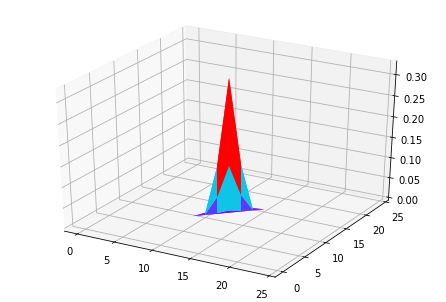

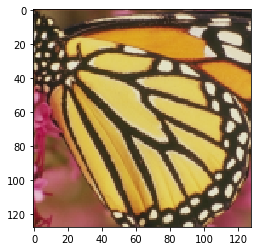

27.039365829273564at K= 0
27.045937069436448at K= 1
27.049875633622996at K= 2
27.052043989765664at K= 3
27.053645751968887at K= 4
27.054802532557318at K= 5
27.05509222072199at K= 6
27.055830585869423at K= 7
27.05594556074267at K= 8
27.056385554623024at K= 9
27.056190470929483at K= 10
27.056045231826488at K= 11
27.05569247766194at K= 12
27.055732521471036at K= 13
27.055568077250243at K= 14
27.05488545115143at K= 15
27.054462867546256at K= 16
27.05351678522128at K= 17
27.05206835147731at K= 18
27.049627702533698at K= 19
27.046969597760437at K= 20
27.043150078114095at K= 21
27.037474586216828at K= 22
27.032943669607295at K= 23


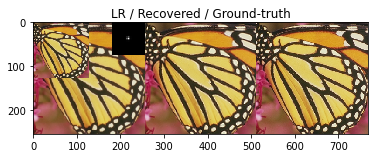

22-07-27 14:12:37.799 : ---1--> butterfly.png -- sf:2 --k: 0 PSNR: 27.03dB
INFO:set3c_sr_gaussian_color_denoising_blind:---1--> butterfly.png -- sf:2 --k: 0 PSNR: 27.03dB


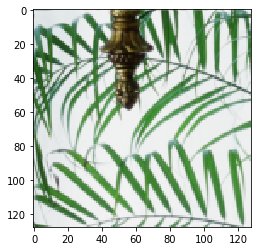

26.553827117557297at K= 0
26.570638091717946at K= 1
26.5809855778156at K= 2
26.588197042448503at K= 3
26.59284981690794at K= 4
26.595901233647105at K= 5
26.597729397609at K= 6
26.599111479551at K= 7
26.600380056554553at K= 8
26.600803158187603at K= 9
26.601292180402666at K= 10
26.601370082831195at K= 11
26.600885219034357at K= 12
26.600816140366753at K= 13
26.600485026789265at K= 14
26.60029752448752at K= 15
26.599053803916746at K= 16
26.597968203005983at K= 17
26.597446243637883at K= 18
26.596416282649848at K= 19
26.594256271747415at K= 20
26.592421410707342at K= 21
26.590805429554855at K= 22
26.58856685629132at K= 23


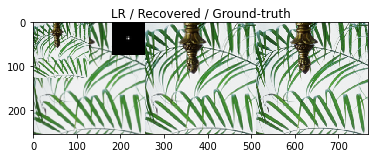

22-07-27 14:12:42.787 : ---2--> leaves.png -- sf:2 --k: 0 PSNR: 26.59dB
INFO:set3c_sr_gaussian_color_denoising_blind:---2--> leaves.png -- sf:2 --k: 0 PSNR: 26.59dB


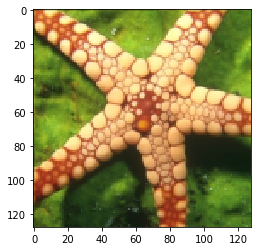

29.843241763896685at K= 0
29.894344139310128at K= 1
29.93245042918714at K= 2
29.961759029379525at K= 3
29.983865600258284at K= 4
30.001925717642504at K= 5
30.016719467725494at K= 6
30.02867011843932at K= 7
30.039526099285602at K= 8
30.049298250558408at K= 9
30.05774683095821at K= 10
30.06595310274203at K= 11
30.072842445873114at K= 12
30.079680605044867at K= 13
30.08578252228744at K= 14
30.09114471793596at K= 15
30.09600815223135at K= 16
30.10106793215226at K= 17
30.105991353803798at K= 18
30.10966754190119at K= 19
30.11254734091628at K= 20
30.11522204522663at K= 21
30.117432654450607at K= 22
30.11972907674661at K= 23


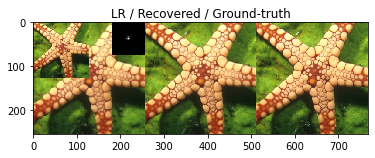

22-07-27 14:12:47.782 : ---3--> starfish.png -- sf:2 --k: 0 PSNR: 30.12dB
INFO:set3c_sr_gaussian_color_denoising_blind:---3--> starfish.png -- sf:2 --k: 0 PSNR: 30.12dB
22-07-27 14:12:47.798 : ------> Average PSNR(RGB) of (set3c) scale factor: (2), kernel: (0) sigma: (0.00): 27.91 dB
INFO:set3c_sr_gaussian_color_denoising_blind:------> Average PSNR(RGB) of (set3c) scale factor: (2), kernel: (0) sigma: (0.00): 27.91 dB


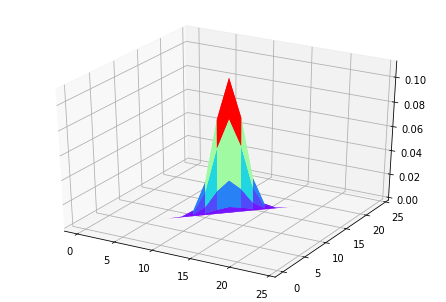

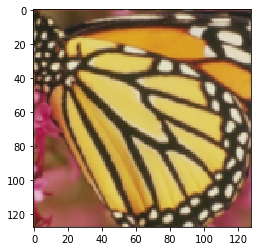

27.686906449721597at K= 0
27.691640045982993at K= 1
27.69197074826404at K= 2
27.692390292191725at K= 3
27.69281626553106at K= 4
27.691923562410857at K= 5
27.690986339179258at K= 6
27.690173720831098at K= 7
27.68920660449835at K= 8
27.688827313150686at K= 9
27.687684079877112at K= 10
27.686736657528435at K= 11
27.68571310559677at K= 12
27.684753358991646at K= 13
27.68384647506659at K= 14
27.68323630162735at K= 15
27.682829155716703at K= 16
27.68192411250562at K= 17
27.681699422915074at K= 18
27.68130578161948at K= 19
27.680980412120476at K= 20
27.68018507573187at K= 21
27.679541103835245at K= 22
27.679392555908642at K= 23


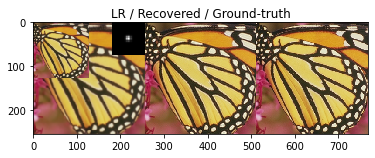

22-07-27 14:12:53.131 : ---1--> butterfly.png -- sf:2 --k: 1 PSNR: 27.68dB
INFO:set3c_sr_gaussian_color_denoising_blind:---1--> butterfly.png -- sf:2 --k: 1 PSNR: 27.68dB


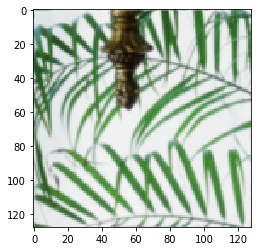

27.441737058335505at K= 0
27.478130758857574at K= 1
27.496005045598114at K= 2
27.506280874916893at K= 3
27.51240705459033at K= 4
27.515902143187713at K= 5
27.518746611064095at K= 6
27.519853945494177at K= 7
27.520162116666032at K= 8
27.520820321514275at K= 9
27.520701270756046at K= 10
27.519986044469103at K= 11
27.519497278527684at K= 12
27.519537280804567at K= 13
27.519318460973096at K= 14
27.51846764375072at K= 15
27.517506145704225at K= 16
27.51677402961068at K= 17
27.51614255739407at K= 18
27.515558463026977at K= 19
27.514373894956144at K= 20
27.513128745555008at K= 21
27.512090734711087at K= 22
27.510880430817423at K= 23


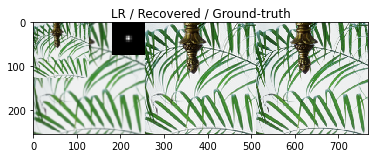

22-07-27 14:12:58.177 : ---2--> leaves.png -- sf:2 --k: 1 PSNR: 27.51dB
INFO:set3c_sr_gaussian_color_denoising_blind:---2--> leaves.png -- sf:2 --k: 1 PSNR: 27.51dB


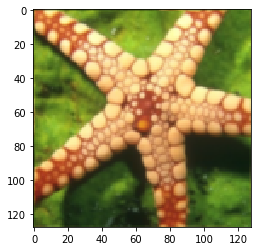

30.414578269791463at K= 0
30.493512085087403at K= 1
30.547490786230803at K= 2
30.587064444284117at K= 3
30.61518652036544at K= 4
30.63631177295776at K= 5
30.654505881722468at K= 6
30.669320411679898at K= 7
30.68080245477678at K= 8
30.691174932073913at K= 9
30.69894587233786at K= 10
30.704650855663406at K= 11
30.709465021267125at K= 12
30.71431634947033at K= 13
30.71812074518604at K= 14
30.72171818207707at K= 15
30.72355694670426at K= 16
30.72483389901871at K= 17
30.72550503971663at K= 18
30.726460972835863at K= 19
30.726980671059735at K= 20
30.726613063088102at K= 21
30.726060259173785at K= 22
30.725241956775015at K= 23


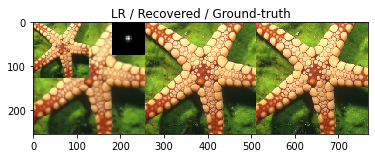

22-07-27 14:13:03.248 : ---3--> starfish.png -- sf:2 --k: 1 PSNR: 30.73dB
INFO:set3c_sr_gaussian_color_denoising_blind:---3--> starfish.png -- sf:2 --k: 1 PSNR: 30.73dB
22-07-27 14:13:03.264 : ------> Average PSNR(RGB) of (set3c) scale factor: (2), kernel: (1) sigma: (0.00): 28.64 dB
INFO:set3c_sr_gaussian_color_denoising_blind:------> Average PSNR(RGB) of (set3c) scale factor: (2), kernel: (1) sigma: (0.00): 28.64 dB
22-07-27 14:13:03.266 : ------> Average PSNR of (set3c) 28.28 dB
INFO:set3c_sr_gaussian_color_denoising_blind:------> Average PSNR of (set3c) 28.28 dB


In [ ]:
for i in [10]:
  iterate(lam =i)
